# Pululagua Inversion Examples



In [2]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [3]:
filename = "./data/pululagua/pulu_real_data.csv"

raw_df, grid = io.import_pululagua(filename)

grid.to_csv("data/pululagua/pulu_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample,Easting,Northing,Altitude,Thickness,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)",...,"[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",total,Md(phi),Sorting,SkG,radius
5,PL12,4105,1558,2358,16.5,165,0.00,0.00,888.30,1203.10,...,19.92,7.91,1.67,0.32,0.03,100.0000,-1.67,2.68,-0.02,4390.716229
24,PL40,1032,-4703,2599,28.0,280,833.76,1492.62,1744.88,1159.76,...,10.37,3.52,0.85,0.18,0.01,100.0000,-4.20,2.96,0.23,4814.896987
25,PL41,1018,-4731,2615,35.0,350,1481.98,564.95,2152.07,1155.80,...,12.18,3.88,0.78,0.15,0.01,100.0000,-4.31,2.73,0.09,4839.285588
4,PL11,5068,-1933,2738,17.0,170,0.00,0.00,524.55,1151.43,...,9.18,3.86,0.83,0.16,0.02,99.9999,-1.63,2.45,0.01,5424.123247
6,PL13,5463,3958,1934,14.0,140,0.00,0.00,286.61,850.53,...,30.46,14.48,3.34,0.66,0.04,100.0000,-0.50,2.42,-0.20,6746.119848


## Preprossessing Steps

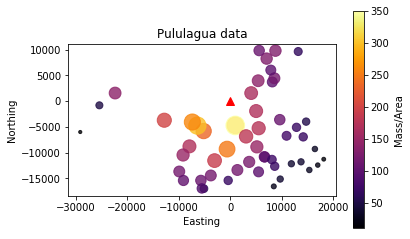

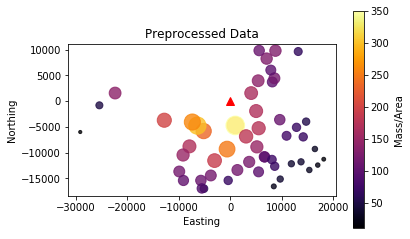

In [4]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("pululagua/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("pululagua/All_trans.png", dpi=200, format='png')
plt.show()

In [5]:
t2_df, _, _, _ = io.read_tephra2("data/pululagua/pulu_out.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)",...,"[3,4)","[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",radius,Residual
0,4105,1558,0,159.345,0.069613,0.363263,1.41018,4.11607,9.11220,15.4036,...,1.57705,0.049929,0.000736,0.000007,5.501030e-08,2.553490e-10,9.146550e-13,2.540160e-15,4390.716229,96.572727
1,1032,-4703,0,180.987,0.057950,0.311125,1.23449,3.66294,8.20795,13.9980,...,2.03938,0.046893,0.000655,0.000007,4.844180e-08,2.248210e-10,8.052870e-13,2.236420e-15,4814.896987,64.638214
2,1018,-4731,0,180.914,0.057607,0.309804,1.23085,3.65573,8.19777,13.9882,...,2.04084,0.046922,0.000655,0.000007,4.846140e-08,2.249120e-10,8.056120e-13,2.237330e-15,4839.285588,51.689714
3,5068,-1933,0,152.806,0.054873,0.307602,1.26261,3.84461,8.78330,15.1939,...,1.58051,0.052108,0.000768,0.000008,5.736520e-08,2.662770e-10,9.537980e-13,2.648870e-15,5424.123247,89.885882
4,5463,3958,0,134.370,0.040083,0.248334,1.10428,3.57868,8.57208,15.3609,...,1.36057,0.057178,0.000869,0.000009,6.522980e-08,3.028070e-10,1.084660e-12,3.012300e-15,6746.119848,95.978571


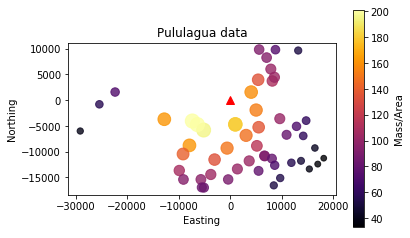

In [6]:
vis.plot_sample(t2_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()

In [44]:
config = io.read_tephra2_config("data/pululagua/pulu_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 19

config["MAX_GRAINSIZE"] = -8
config["MIN_GRAINSIZE"] = 11

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 0.1

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 2500.0,
 'PLUME_HEIGHT': 27000.0,
 'ALPHA': 1.1,
 'BETA': 1.1,
 'ERUPTION_MASS': 250000000000.0,
 'MAX_GRAINSIZE': -8,
 'MIN_GRAINSIZE': 11,
 'MEDIAN_GRAINSIZE': -0.2,
 'STD_GRAINSIZE': 2.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 92066.0,
 'FALL_TIME_THRESHOLD': 3600.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 19,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 0.1}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-7.5,1024.0,"[-8,-7)",-8.0,9.932775e-05,-7.0
1,-6.5,1024.0,"[-7,-6)",-7.0,6.161097e-04,-6.0
2,-5.5,1024.0,"[-6,-5)",-6.0,2.976267e-03,-5.0
3,-4.5,1024.0,"[-5,-4)",-5.0,1.119727e-02,-4.0
4,-3.5,1024.0,"[-4,-3)",-4.0,3.280791e-02,-3.0
5,-2.5,1024.0,"[-3,-2)",-3.0,7.486374e-02,-2.0
6,-1.5,1024.0,"[-2,-1)",-2.0,1.330426e-01,-1.0
7,-0.5,1024.0,"[-1,0)",-1.0,1.841351e-01,0.0
8,0.5,1233.5,"[0,1)",0.0,1.984763e-01,1.0
9,1.5,1443.0,"[1,2)",1.0,1.666123e-01,2.0


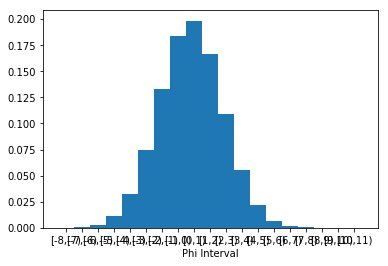

In [45]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [46]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 0,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.04688 seconds
Dataframe Merge time: 0.06250 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.03125 seconds
Total time: 0.14062 seconds


,Northing,Easting,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)",...,"[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",MassArea,radius,Residual
0,1558,4105,0.053442,0.279426,1.086548,3.176708,7.045958,11.939054,15.536734,15.354751,...,0.049797,0.000630,0.000006,4.262808e-08,1.944259e-10,6.903537e-13,1.908856e-15,219.327182,4390.716229,132.925565
1,-4703,1032,0.048469,0.260849,1.037133,3.083410,6.924117,11.838908,15.507187,15.397908,...,0.050480,0.000638,0.000006,4.316619e-08,1.968791e-10,6.990639e-13,1.932940e-15,216.594418,4814.896987,77.355149
2,-4731,1018,0.048206,0.259874,1.034617,3.078996,6.919316,11.837095,15.510881,15.405936,...,0.050538,0.000639,0.000006,4.321835e-08,1.971170e-10,6.999085e-13,1.935275e-15,216.333033,4839.285588,61.809438
3,-1933,5068,0.042363,0.238150,0.979702,2.989165,6.843452,11.868177,15.706526,15.712701,...,0.052361,0.000664,0.000006,4.494115e-08,2.049757e-10,7.278132e-13,2.012433e-15,208.038721,5424.123247,122.375718
4,3958,5463,0.030296,0.188481,0.840588,2.730554,6.555441,11.777533,15.995713,16.307772,...,0.056701,0.000723,0.000007,4.892964e-08,2.231678e-10,7.924087e-13,2.191042e-15,191.079825,6746.119848,136.485590


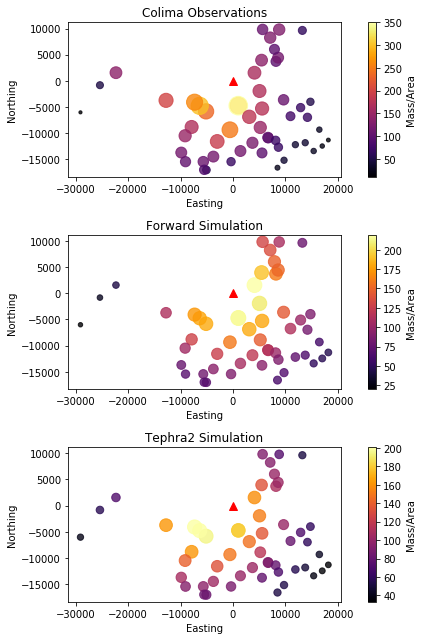

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


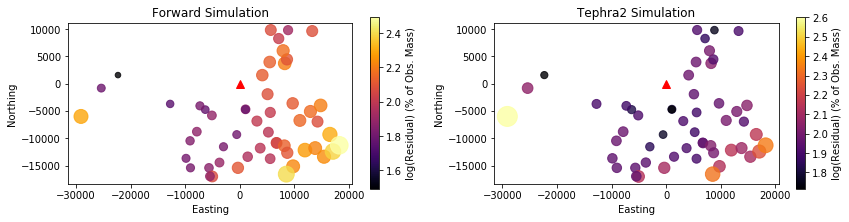

In [47]:
fig, axs = plt.subplots(3,1, figsize=(
        8,9), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation", cbar_label="Mass/Area", ax=axs[1])
# vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
#             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[2])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(
        12,3), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
# vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
#             title="Tephra2 Simulation (Const. Wind)", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])




plt.tight_layout()
plt.show()

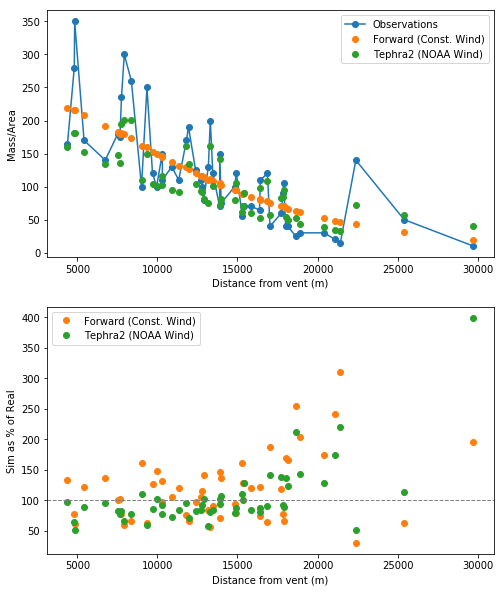

In [49]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C2o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Forward Simulation========
a* = -3.13120	b* = -3.73132            	h1* = 0.92210
a = 1.04367	b = 1.02396	h1 = 26874.99994
Success: True, Optimization terminated successfully.
Iterations: 116
SSE: 0.3568666181504471


,Height,Suspended Mass
0,4375.0,1.975207e+10
1,6250.0,2.031663e+10
2,8125.0,2.063236e+10
3,10000.0,2.084050e+10
4,11875.0,2.098524e+10
5,13750.0,2.108540e+10
6,15625.0,2.114954e+10
7,17500.0,2.118049e+10
8,19375.0,2.117617e+10
9,21250.0,2.112768e+10


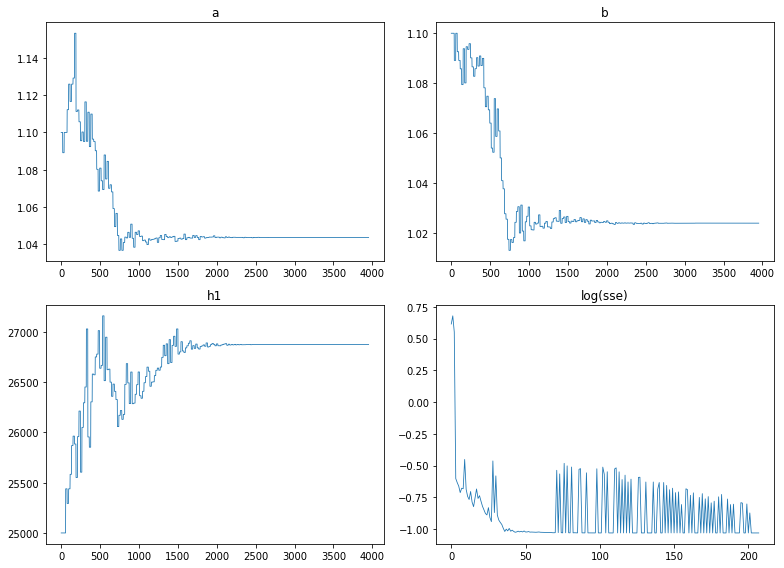

========T2 Simulation========
a* = -1.95935	b* = -1.48707            	h1* = 1.88943
a = 1.14095	b = 1.22604	h1 = 34388.49594
Success: True, Optimization terminated successfully.
Iterations: 89
SSE: 98.91766388910864


,Height,Suspended Mass
0,4375.0,1.417347e+10
1,6250.0,1.540189e+10
2,8125.0,1.605553e+10
3,10000.0,1.644235e+10
4,11875.0,1.666366e+10
5,13750.0,1.676467e+10
6,15625.0,1.676800e+10
7,17500.0,1.668478e+10
8,19375.0,1.651878e+10
9,21250.0,1.626791e+10


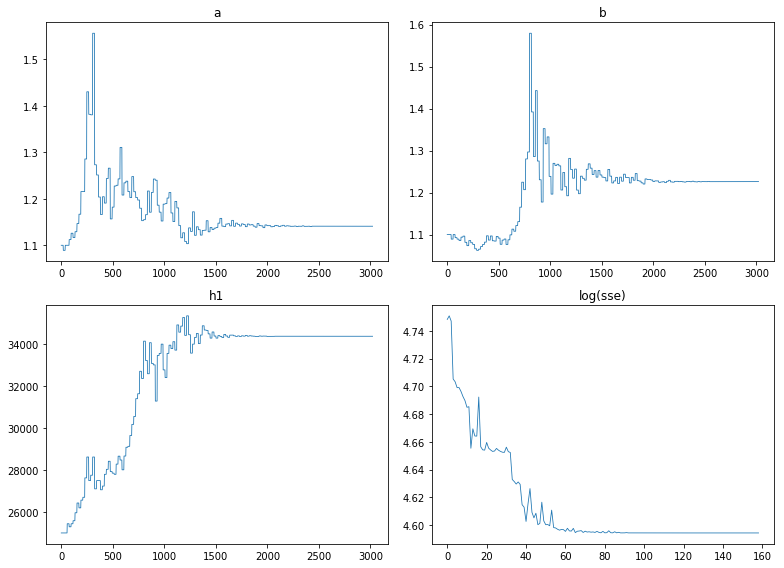

========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:426: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 13.98971	b* = 16.95571            	h1* = 5.30373
a = 1190292.62264	b = 23108528.49610	h1 = 39801.57390
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 558432504983.3914


,Height,Suspended Mass
0,4375.0,2.500000e+11
1,6250.0,0.000000e+00
2,8125.0,0.000000e+00
3,10000.0,0.000000e+00
4,11875.0,0.000000e+00
5,13750.0,0.000000e+00
6,15625.0,0.000000e+00
7,17500.0,0.000000e+00
8,19375.0,0.000000e+00
9,21250.0,0.000000e+00


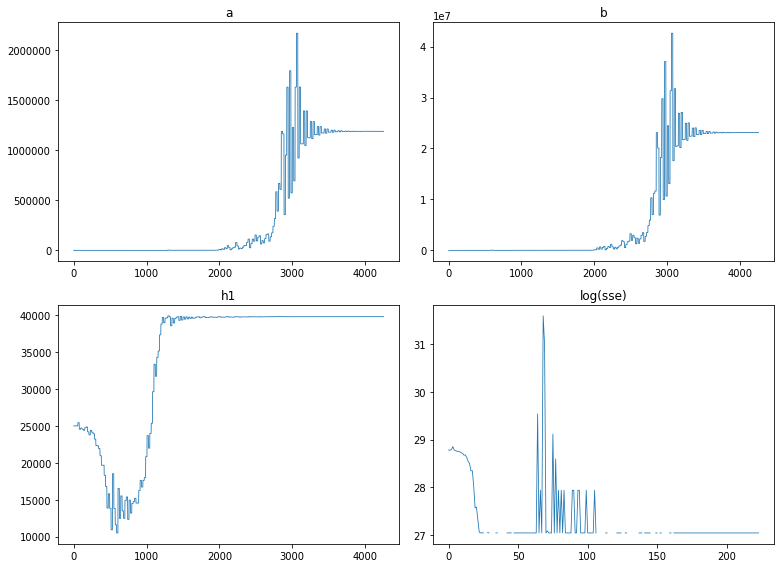

In [50]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 25000
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True
}

H = 40000

wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Forward Simulation", "T2 Simulation", "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], H, 0,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



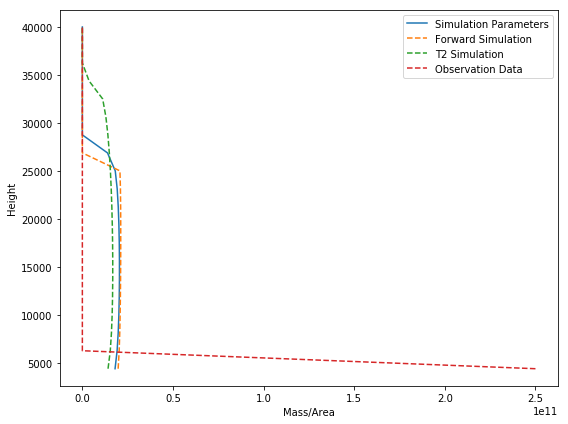

In [51]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Forward Simulation========


c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


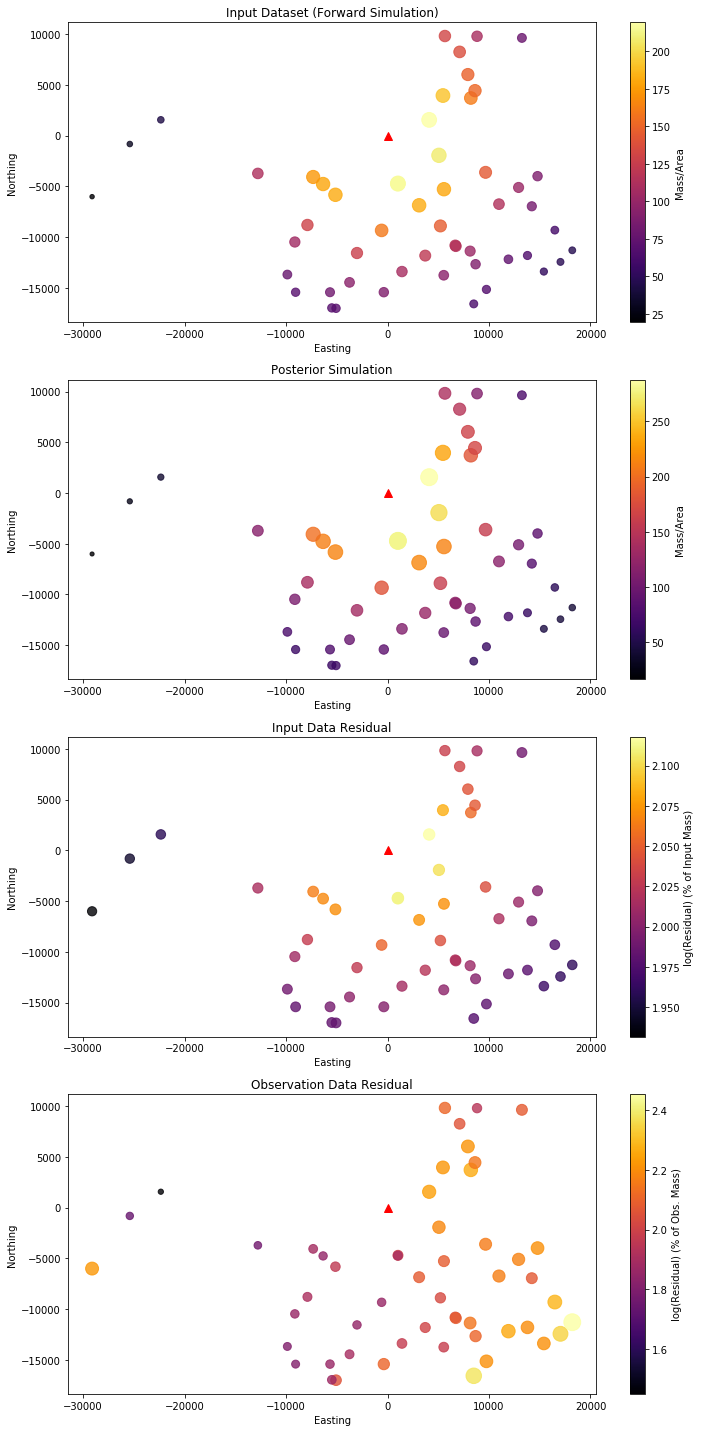

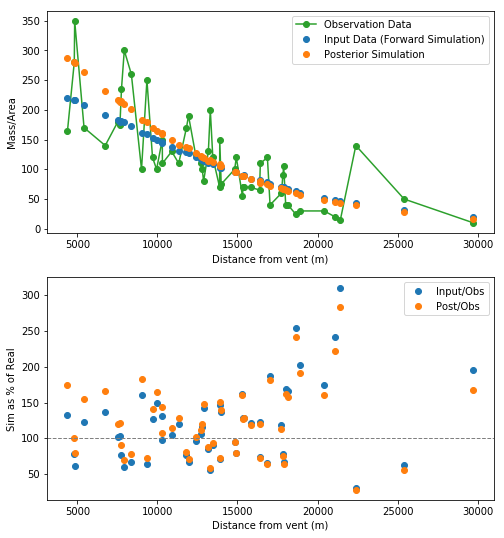

========T2 Simulation========


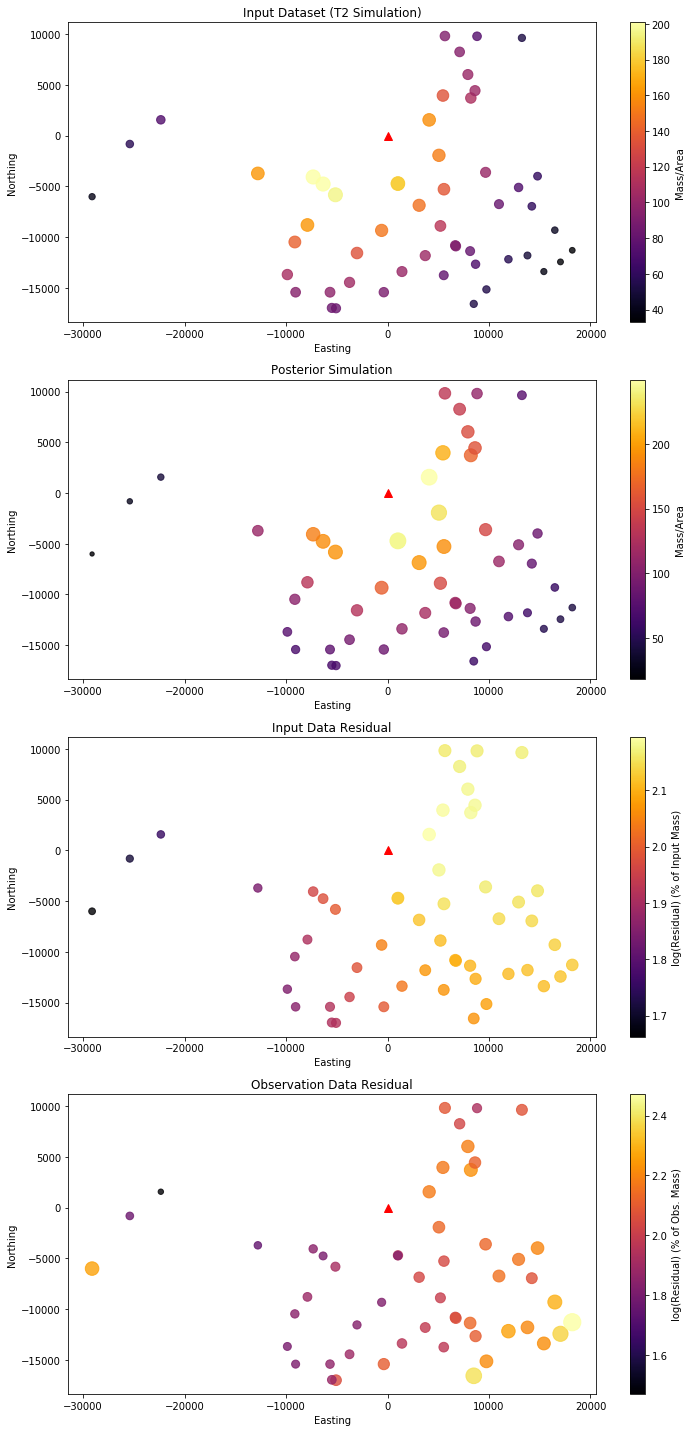

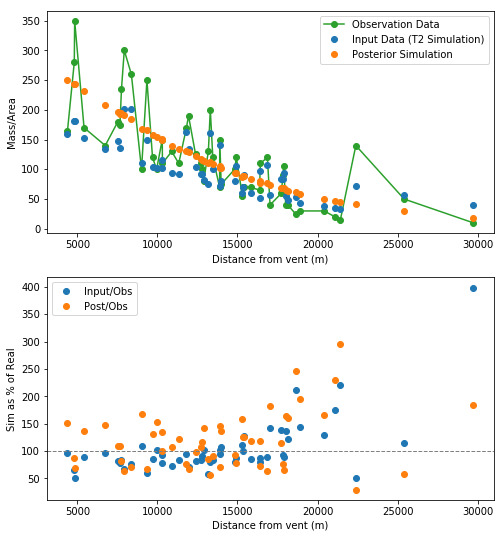

========Observation Data========


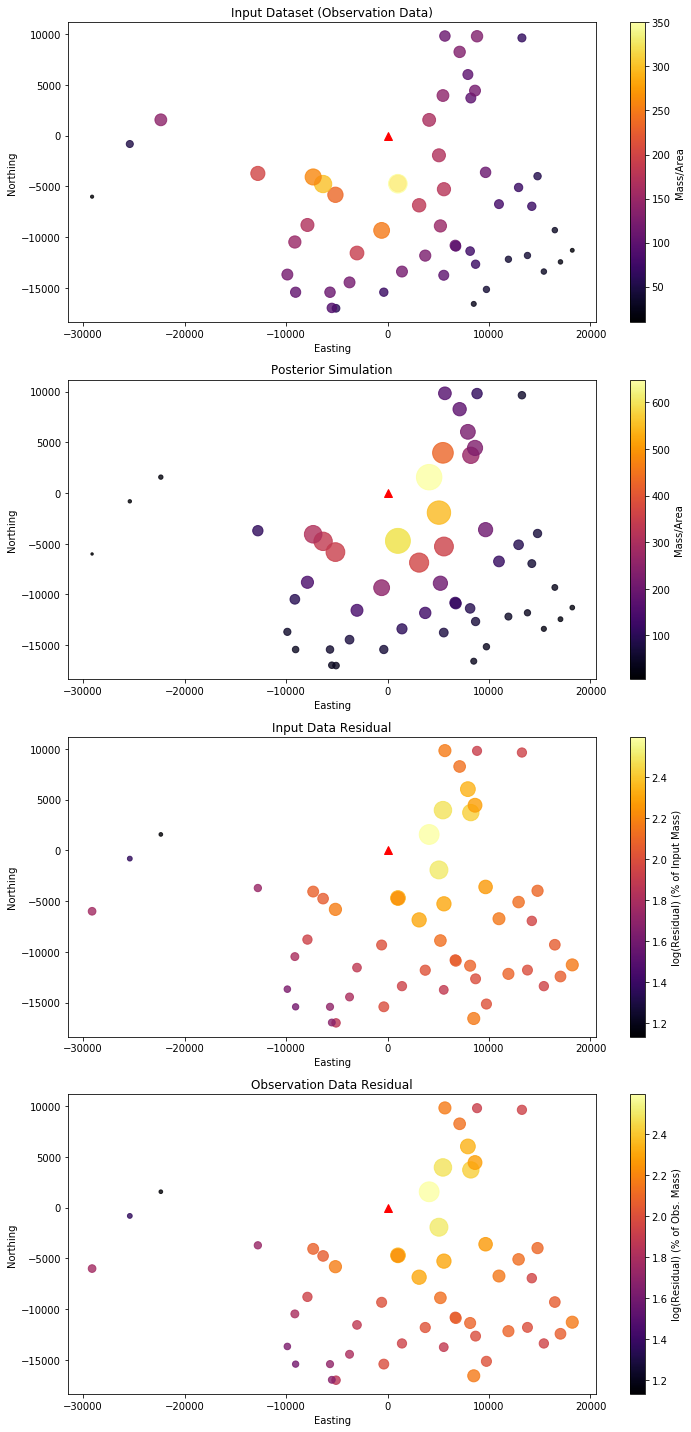

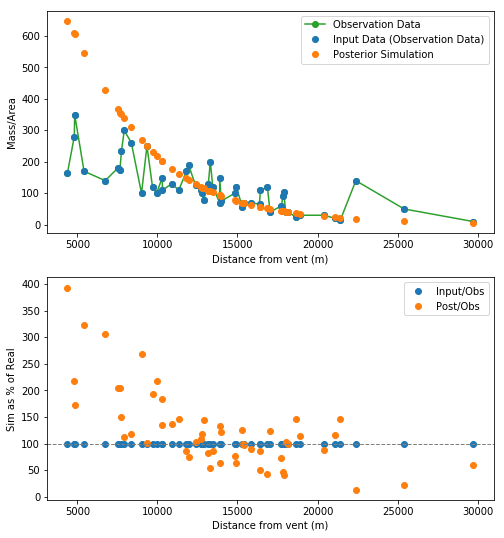

In [52]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
                title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
                title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [14]:
# fig, axs = plt.subplots(2,1, figsize=(
#         8, 9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(obs_df["radius"].values, rotdf["MassArea"].values, 'C0-', label="Obs")
# axs[0].plot(df_merge["radius"].values, df_merge["MassArea"].values, 'C1-', label="Prior")
# axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C2-', label="Post")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3-', label="T2")
# axs[0].legend()
# axs[0].set_xlabel("Distance from vent (m)")
# axs[0].set_ylabel("Mass/Area")


# axs[1].plot(prior_res_obs["radius"].values, prior_res_obs["MassArea"].values, 'C1-', label="Prior/Obs")
# axs[1].plot(post_res_obs["radius"].values, post_res_obs["MassArea"].values, 'C2-', label="Post/Obs")
# axs[1].plot(t2_res_df["radius"].values, t2_res_df["MassArea"].values, 'C3-', label="T2/Obs")
# axs[1].legend()
# axs[1].set_xlabel("Distance from vent (m)")
# axs[1].set_ylabel("Residual (%)")
# plt.show()

========Forward Simulation========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:675: RuntimeWarning: divide by zero encountered in double_scalars
  wind_speed = u/np.sin(wind_angle)
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:680: RuntimeWarning: invalid value encountered in double_scalars
  v_wind_adj = np.sin(wind_angle)*windspeed_adj
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:682: RuntimeWarning: invalid value encountered in double_scalars
  x_adj = u_wind_adj*fall_time_adj


a* = -0.03284	b* = -1.91733	            h1* = 2.84766	u* = -21.04263	v* = -18.73925
a = 1.96769	b = 1.14700	            h1 = 28310.06878	u = 0.00000	v = 0.00000
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 611
SSE: 115.83384795999885


,Height,Suspended Mass
0,3875.0,1.901384e+09
1,5250.0,3.687035e+09
2,6625.0,5.409472e+09
3,8000.0,7.077425e+09
4,9375.0,8.693191e+09
5,10750.0,1.025627e+10
6,12125.0,1.176436e+10
7,13500.0,1.321352e+10
8,14875.0,1.459816e+10
9,16250.0,1.591053e+10


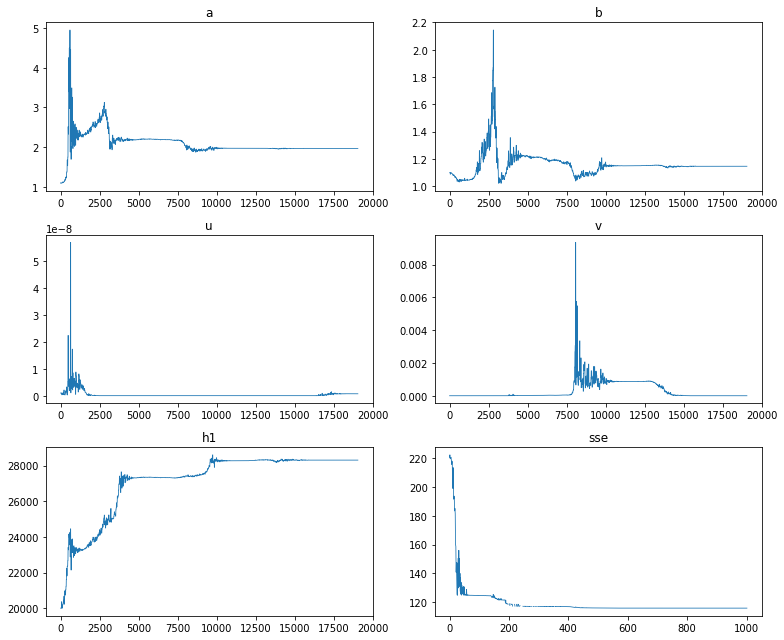

Forward Simulation Run Time: 273.31250 seconds


========T2 Simulation========
a* = -0.07073	b* = -1.98646	            h1* = 3.34816	u* = -28.14344	v* = -25.49767
a = 1.93171	b = 1.13718	            h1 = 28963.84992	u = 0.00000	v = 0.00000
Success: True, Optimization terminated successfully.
Iterations: 457
SSE: 114.31802380256872


,Height,Suspended Mass
0,3875.0,1.888178e+09
1,5250.0,3.574034e+09
2,6625.0,5.172096e+09
3,8000.0,6.703303e+09
4,9375.0,8.175975e+09
5,10750.0,9.593518e+09
6,12125.0,1.095662e+10
7,13500.0,1.226404e+10
8,14875.0,1.351280e+10
9,16250.0,1.469806e+10


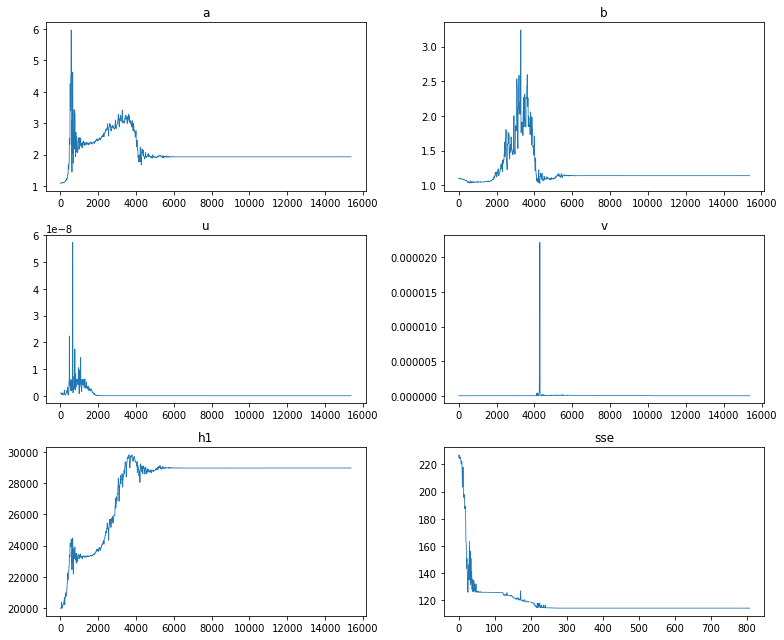

T2 Simulation Run Time: 218.60938 seconds


========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:426: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 13.68011	b* = 16.58259	            h1* = 14.77622	u* = -149.21631	v* = -189.20641
a = 873367.65549	b = 15912031.27009	            h1 = 29999.98852	u = 0.00000	v = 0.00000
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 558
SSE: 31752934084.433132


,Height,Suspended Mass
0,3875.0,2.500000e+11
1,5250.0,0.000000e+00
2,6625.0,0.000000e+00
3,8000.0,0.000000e+00
4,9375.0,0.000000e+00
5,10750.0,0.000000e+00
6,12125.0,0.000000e+00
7,13500.0,0.000000e+00
8,14875.0,0.000000e+00
9,16250.0,0.000000e+00


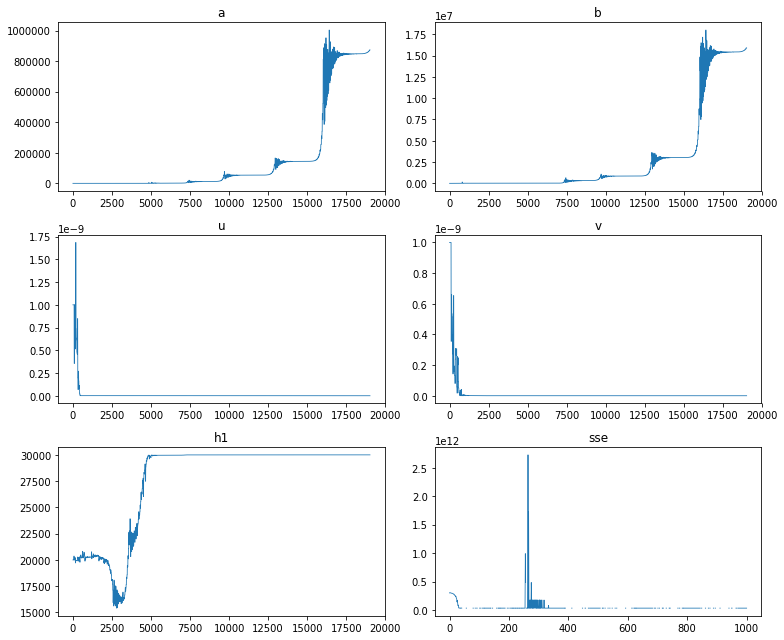

Observation Data Run Time: 271.53125 seconds


Total Run Time: 763.45312 seconds


In [41]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 20000,
    "u": 1e-9,
    "v": 1e-9
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True
}

H = 40000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(200)

names = ["Forward Simulation", 
         "T2 Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_wind_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, 
        config["ERUPTION_MASS"], phi_steps,
        config["DIFFUSION_COEFFICIENT"], 
        config["FALL_TIME_THRESHOLD"], 
        config["EDDY_CONST"],
        invert_params = invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, trace, wind_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-2]
    
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    wind_trace = np.array(wind_trace)
    fig, axs = plt.subplots(3,2, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(wind_trace[:,0], linewidth=.8)
    axs[2].set_title("u")

    axs[3].plot(wind_trace[:,1], linewidth=.8)
    axs[3].set_title("v")


    axs[4].plot(trace[:,2], linewidth=.8)
    axs[4].set_title("h1")

    axs[5].plot(sse_trace, linewidth=.8)
    axs[5].set_title("sse")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f seconds\n\n"%(name, run_time))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f seconds"%(total_run_time))

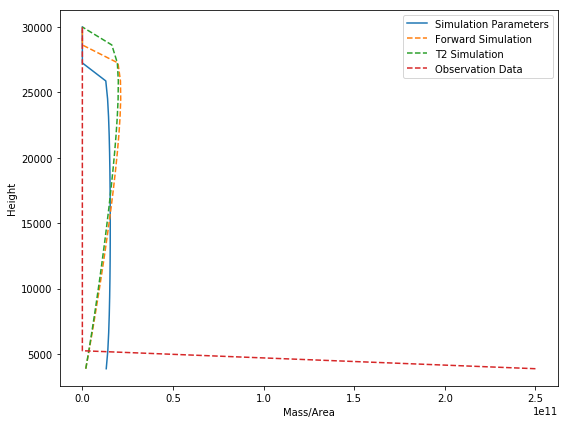

In [42]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

In [43]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]
    u = params["u"]
    v = params["v"]
    post_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        params["h1"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    

========Forward Simulation========


TypeError: gaussian_stack_forward() missing 2 required positional arguments: 'eddy_constant' and 'fall_time_threshold'

In [ ]:


a = [1,2,3,4,5,6]

b, c, d, \
    e, f, g = a

print(b, c, d, e, f, g)